In [17]:
from math import sqrt
from numpy import concatenate
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error



data_set = pd.read_csv('/Users/shenghaoisyummy/Capstone/feature_extraction_data_dummis_del_outlier_4000.csv', index_col=0)

In [18]:
list(data_set)
data_set.head()
def time_to_total_minutes(df):
    df['target_minitues'] = df['arrv_late_time']/60

time_to_total_minutes(data_set)

In [19]:
data_Y = data_set[['target_minitues']]
data_set.drop(['actual_station_arrv_time_hours','actual_station_arrv_time_minutes', 'arrv_late_time', 'dprt_late_time', 'actual_station_dprt_time_hours', 'actual_station_dprt_time_minutes', 'target_minitues'], axis=1, inplace=True)


In [20]:
data_X = VarianceThreshold(threshold=3).fit_transform(data_set)

In [21]:
data_Y

,target_minitues
1,-1.0
2,-1.0
3,-1.0
4,-2.0
5,-1.0
6,-1.0
7,-1.0
8,-1.0
9,-1.0
10,-2.0


In [22]:
# make sure value as float
data_X_values = data_X
data_X_values = data_X_values.astype('float32')

data_Y_values = data_Y.values
data_Y_values = data_Y_values.astype('float32')
# normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
data_X_values = scaler.fit_transform(data_X_values)
data_Y_values = scaler.fit_transform(data_Y_values)
# split train test
train_X, test_X, train_y, test_y = train_test_split(data_X_values, data_Y_values, test_size = 0.2, random_state = 4)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# get the dimension
input_data_features = train_X.shape[2] 

In [23]:
model = Sequential()

Train on 15999 samples, validate on 4000 samples
Epoch 1/15
 - 160s - loss: 0.0248 - val_loss: 0.0217
Epoch 2/15
 - 150s - loss: 0.0221 - val_loss: 0.0205
Epoch 3/15
 - 149s - loss: 0.0215 - val_loss: 0.0196
Epoch 4/15
 - 151s - loss: 0.0211 - val_loss: 0.0201
Epoch 5/15
 - 147s - loss: 0.0210 - val_loss: 0.0199
Epoch 6/15
 - 149s - loss: 0.0207 - val_loss: 0.0199
Epoch 7/15
 - 147s - loss: 0.0206 - val_loss: 0.0195
Epoch 8/15
 - 148s - loss: 0.0205 - val_loss: 0.0195
Epoch 9/15
 - 148s - loss: 0.0204 - val_loss: 0.0195
Epoch 10/15
 - 153s - loss: 0.0203 - val_loss: 0.0193
Epoch 11/15
 - 1543s - loss: 0.0202 - val_loss: 0.0191
Epoch 12/15
 - 149s - loss: 0.0201 - val_loss: 0.0193
Epoch 13/15
 - 148s - loss: 0.0200 - val_loss: 0.0193
Epoch 14/15
 - 147s - loss: 0.0200 - val_loss: 0.0199
Epoch 15/15
 - 149s - loss: 0.0199 - val_loss: 0.0194


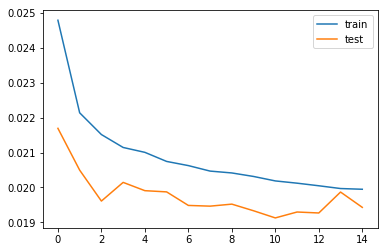

Test RMSE: 3.145


In [24]:

model.add(LSTM(128,  dropout=0, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=15, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)